# Tutorial on Loading and Editing of Scenes

This notebook explains how to load and edit scenes with Sionna's [ray tracing (RT) module](https://nvlabs.github.io/sionna/rt/index.html). You will:

- Use the `load_scene()` function to load a scene with and without merging objects
- Learn how to add and remove objects from a scene
- Learn how to translate, rotate, and scale objects within a scene

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import drjit as dr
import mitsuba as mi

# Import or install Sionna
try:
    import sionna.rt
except ImportError as e:
    import os
    os.system("pip install sionna-rt")
    import sionna.rt

no_preview = True # Toggle to False to use the preview widget
                  # instead of rendering for scene visualization

from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera,\
                      PathSolver, ITURadioMaterial, SceneObject

## Loading Scenes and Merging Objects

Loading a scene with Sionna RT is done using the `load_scene()` function. By default, this function merges objects that share similar properties, such as radio materials. This is done because reducing the number of objects in a scene enables significant speed-ups for ray tracing.

Merging shapes can be disabled using the `merge_shapes` flag of `load_scene()`:

In [2]:
scene = load_scene(sionna.rt.scene.simple_street_canyon,
                   merge_shapes=False) # Disable merging of objects

Let's now print the objects that make up the scene and their constituent materials. We can see that the objects have not been merged,
as radio materials appear multiple times in the composition of objects.

In [3]:
for name, obj in scene.objects.items():
    print(f'{name:<15}{obj.radio_material.name}')

building_1     itu_glass
building_6     itu_wood
building_5     itu_glass
building_4     itu_marble
building_3     itu_marble
building_2     itu_brick
floor          itu_concrete


Let's now reload the scene with the merging of objects enabled:

In [4]:
scene = load_scene(sionna.rt.scene.simple_street_canyon,
                   merge_shapes=True) # Enable merging of objects (default)

for name, obj in scene.objects.items():
    print(f'{name:<15}{obj.radio_material.name}')

floor          itu_concrete
building_2     itu_brick
no-name-1      itu_marble
building_6     itu_wood
no-name-2      itu_glass


We can see that objects sharing the same radio materials have been merged, as each radio material appears only once in the composition of objects.

The function `load_scene()` also allows the exclusion of specific objects from the merging operation through the use of regular expressions. Please see the [Python documentation](https://docs.python.org/3/library/re.html) for details about the regular expression syntax.
As an example, let's exclude buildings with indices smaller than 3 from the merging process:

In [5]:
scene = load_scene(sionna.rt.scene.simple_street_canyon,
                   merge_shapes=True, # Enable merging of objects
                   merge_shapes_exclude_regex=r'building_[0-2]$') # Exclude from merging
                                                                  # buildings with indices < 3

for name, obj in scene.objects.items():
    print(f'{name:<15}{obj.radio_material.name}')

building_1     itu_glass
building_2     itu_brick
floor          itu_concrete
no-name-3      itu_marble
building_5     itu_glass
building_6     itu_wood


We can see that "building_1" and "building_2" have not been merged. As a result, "building_5" has not been merged either, as it has no other objects to be merged with.

## Editing Scenes

Let's load a more complex scene and visualize it.

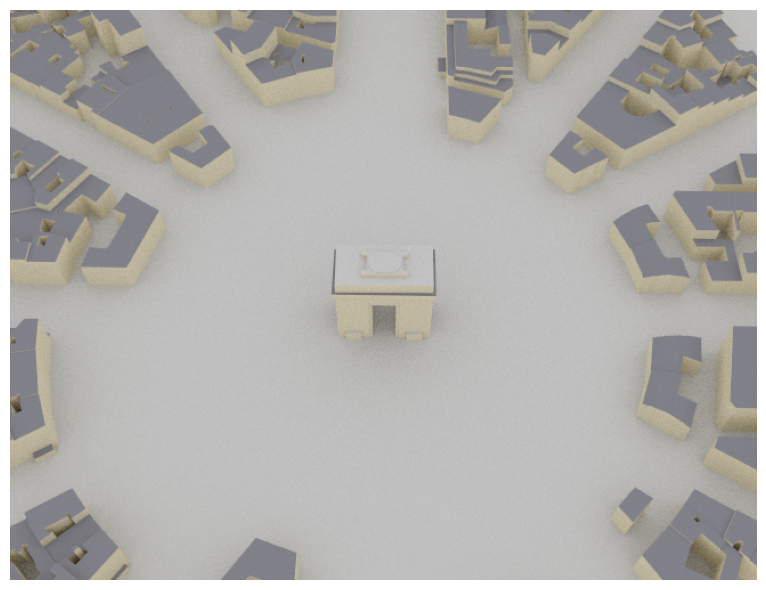

In [6]:
scene = load_scene(sionna.rt.scene.etoile) # Objects are merged by default

cam = Camera(position=[-360,145,400], look_at=[-115,33,1.5])
if no_preview:
    scene.render(camera=cam);
else:
    scene.preview();

Next, we will add a few objects to the scene.

In Sionna RT, adding an object to a scene is achieved by instantiating a new [`SceneObject`](https://nvlabs.github.io/sionna/rt/api/scene_object.html) from a mesh and then adding the object to the scene using `Scene.add()`. When the `SceneObject` is instantiated, the radio material constituting the object needs to be specified.

In the following example, we will add cars made of metal to the previously loaded scene.

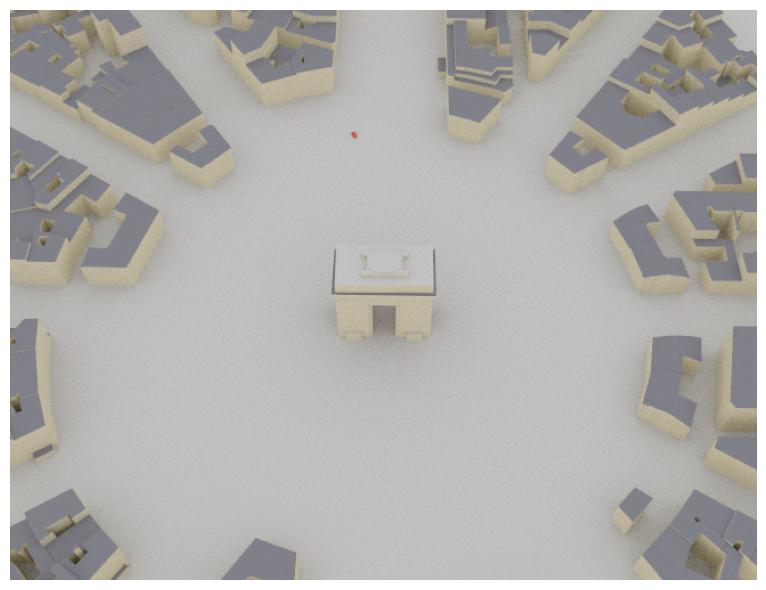

In [7]:
# Number of cars to add
num_cars = 10

# Radio material constituing the cars
# We use ITU metal, and use red color for visualization to
# make the cars easily discernible
car_material = ITURadioMaterial("car-material",
                                "metal",
                                thickness=0.01,
                                color=(0.8, 0.1, 0.1))

# Instantiate `num_cars` cars sharing the same mesh and material
cars = [SceneObject(fname=sionna.rt.scene.low_poly_car, # Simple mesh of a car
                    name=f"car-{i}",
                    radio_material=car_material)
        for i in range(num_cars)]

# Add the list of newly instantiated objects to the scene
scene.edit(add=cars)

if no_preview:
    scene.render(camera=cam);
else:
    scene.preview();

We can see the red cars in the scene, but because they are all located at the same position, it appears that only a single car was added to the scene.

In the next cell, we will position the cars in the scene and also set their orientations.

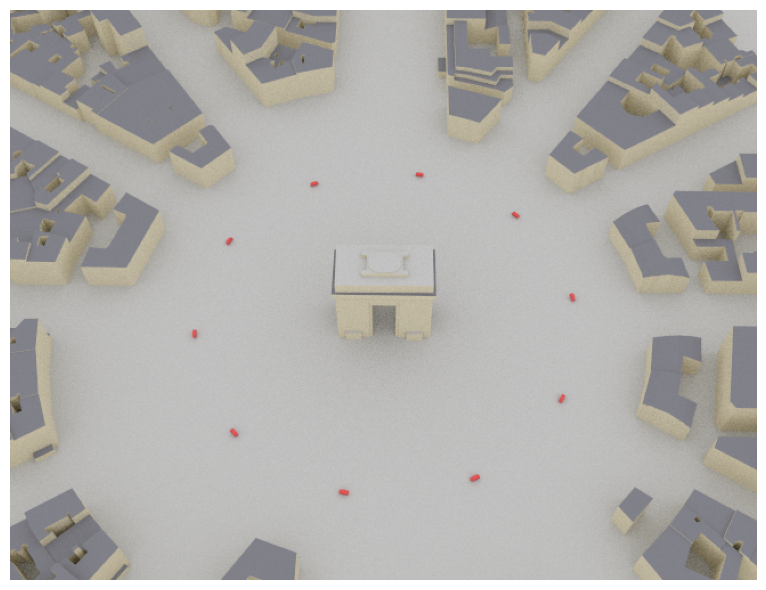

In [8]:
# Positions 
# Car are positioned in a circle around the central monument
# Center of the circle
c = mi.Point3f(-127, 37, 1.5)
# Radius of the circle
r = 100
# Angles at which cars are positioned
thetas = dr.linspace(mi.Float, 0., dr.two_pi, num_cars, endpoint=False)
# Cars positions
cars_positions = c + mi.Point3f(dr.cos(thetas), dr.sin(thetas), 0.)*r

# Orientations
# Compute points the car "look-at" to set their orientation
d = dr.normalize(cars_positions - c)
# Tangent vector to the circle at the car position
look_at_dirs = mi.Vector3f(d.y, -d.x, 0.)
look_at_points = cars_positions + look_at_dirs

# Set the cars positions and orientations
for i in range(num_cars):
    cars[i].position = mi.Point3f(cars_positions.x[i], cars_positions.y[i], cars_positions.z[i])
    cars[i].look_at(mi.Point3f(look_at_points.x[i], look_at_points.y[i], look_at_points.z[i]))

if no_preview:
    scene.render(camera=cam);
else:
    scene.preview();

Objects can also be scaled. This is useful, for example, when the scale of the mesh from which the object is built does not suit the scene.

To illustrate this feature, let's scale the first car to be twice as large as the other cars.

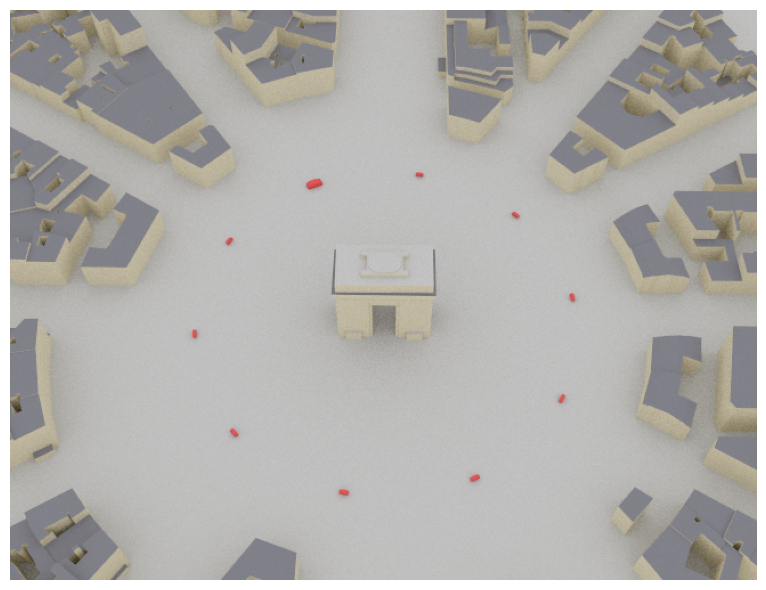

In [9]:
cars[0].scaling = 2.0

if no_preview:
    scene.render(camera=cam);
else:
    scene.preview();

Finally, objects can be removed from the scene using the `Scene.edit()` function.

To illustrate this, let's remove the last car we have added.

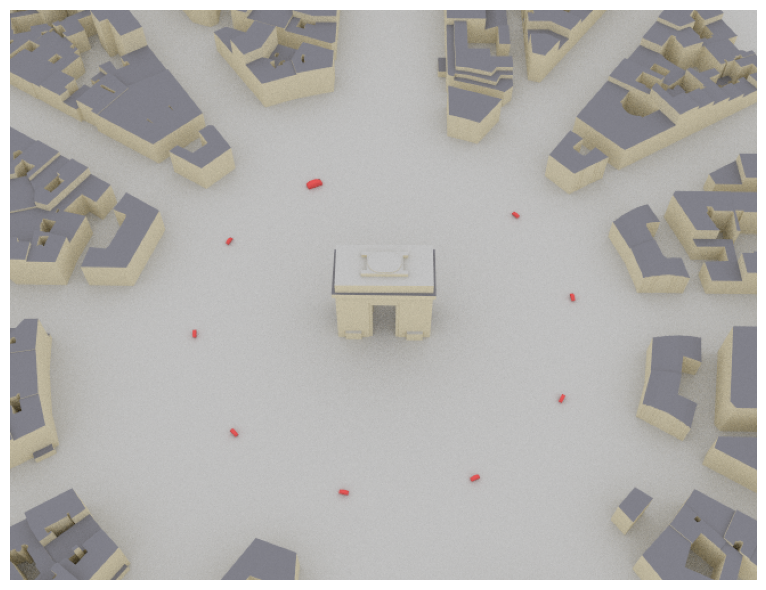

In [10]:
scene.edit(remove=[cars[-1]])

if no_preview:
    scene.render(camera=cam);
else:
    scene.preview();

## Path Computation with the Edited Scene

Let's now compute radio propagation paths on the edited scene.

We start by adding a transmitter on the roof of an arbitrarily selected building, as well as a receiver on top of each car.
We also set the transmitter and receiver arrays.

In [11]:
# Add a transmitter on top of a building
scene.remove("tx")
scene.add(Transmitter("tx", position=[-36.59, -65.02, 25.], display_radius=2))

# Add a receiver on top of each car
for i in range(num_cars):
    scene.remove(f"rx-{i}")
    scene.add(Receiver(f"rx-{i}", position=[cars_positions.x[i],
                                            cars_positions.y[i],
                                            cars_positions.z[i] + 3],
                      display_radius=2))


# Set the transmit and receive antenna arrays
scene.tx_array = PlanarArray(num_cols=1,
                             num_rows=1,
                             pattern="iso",
                             polarization="V")
scene.rx_array = scene.tx_array

We are now ready to compute paths.

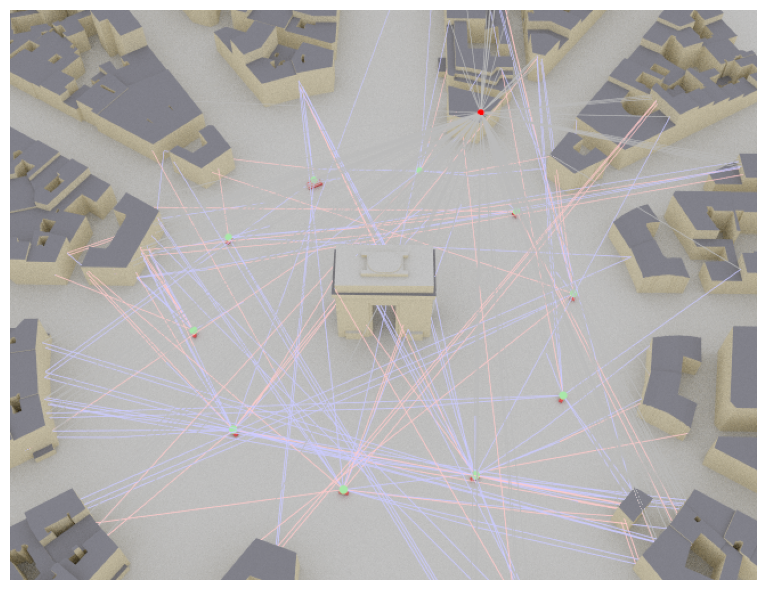

In [12]:
p_solver = PathSolver()
paths = p_solver(scene, max_depth=5)

if no_preview:
    scene.render(camera=cam, paths=paths);
else:
    scene.preview(paths=paths);

## Summary

A scene is loaded using the `load_scene()` function, which by default merges objects sharing similar properties, such as radio materials. Merging of objects can be disabled by setting the `merge_shapes` flag to `False`; however, this can incur a significant slowdown in the ray tracing process. Alternatively, specific objects can be removed from the merging process using the `merge_shapes_exclude_regex` parameter.

Scene objects can be instantiated from meshes and added to a scene using `Scene.edit()`. This function can also be used to remove objects from a scene. Note that to optimize performance and reduce processing time, it is recommended to use a single call to this function with a list of objects to add and/or remove, rather than making multiple individual calls to edit scene objects.